In [4]:
import warnings; warnings.simplefilter('ignore')

In [5]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ,QuantumRegister,ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *



IBMQ.save_account("d769530c2ea8a525a21d7acb2abda532190f128eb1582c3f70a846ec53c4a0640292bb275b07c0e41652e7112a1d82ed409282ed09e53af203c39f4d469d6729")

configrc.store_credentials:WARNING:2021-03-11 20:23:36,149: Credentials already present. Set overwrite=True to overwrite.


In [6]:
from numpy import flip,array,binary_repr,insert

In [14]:
#Grover Iterations subcircuit
def get_grover_iteration_subcircuit(fit_reg_size):
    fit_qreg = QuantumRegister(fit_reg_size+1,"fqreg")
    oracle_ws = QuantumRegister(1,"ows")
    grover_circ = QuantumCircuit(fit_qreg,oracle_ws,name ="U$_s$")

    grover_circ.h(fit_qreg)
    grover_circ.x(fit_qreg)

    grover_circ.h(fit_reg_size)

    grover_circ.mct(list(range(fit_reg_size)), fit_reg_size)  # multi-controlled-toffoli

    grover_circ.h(fit_reg_size)


    grover_circ.x(fit_qreg)
    grover_circ.h(fit_qreg)
    grover_circ.h(oracle_ws)

    #grover_circ.draw(output='mpl', plot_barriers=False, filename="grover_oracle_adder.png") 
    return grover_circ.to_instruction()

In [15]:
def get_adder_instruction():
    def majority(circ,a,b,c):
        circ.cx(c,b)
        circ.cx(c,a)
        circ.ccx(a, b, c)
    def unmaj(circ,a,b,c):
        circ.ccx(a, b, c)
        circ.cx(c, a)
        circ.cx(a, b)
    def adder_4_qubits(p, a0, a1, a2, a3, b0, b1, b2, b3, cin, cout):
        majority(p, cin, b0, a0)
        majority(p, a0, b1, a1)
        majority(p, a1, b2, a2)
        majority(p, a2, b3, a3)
        p.cx(a3, cout)
        unmaj(p, a2, b3, a3)
        unmaj(p, a1, b2, a2)
        unmaj(p, a0, b1, a1)
        unmaj(p, cin, b0, a0)
    a = QuantumRegister(4, "aop")
    b = QuantumRegister(4, "bop")
    c = QuantumRegister(2, "carry")

    add_circ = QuantumCircuit(a, b, c,name="Add")
    adder_4_qubits(add_circ, a[0], a[1], a[2], a[3], b[0], b[1], b[2], b[3], c[0], c[1])
    add8 = add_circ.to_instruction()
    #add_circ.draw(output='mpl', plot_barriers=False, filename="adder.png") 
    return add8

In [16]:
ireg = QuantumRegister(2,"ireg")
qreg = QuantumRegister(5,"qreg")
oracle = QuantumRegister(1,"oracle")
carry = QuantumRegister(2,"carry")
val = QuantumRegister(4,"val")
neg_val = QuantumRegister(4,"neg_val")
creg = ClassicalRegister(2,"creg")
qc = QuantumCircuit(ireg,qreg,oracle,carry,neg_val,val,creg)
qc.h(oracle)
qc.h(ireg)

In [17]:
"""Try circuit with more than 2 values. 
Ufit Circuit
00 => 00000 -> Invalid => 0 1111
01 => 00001 -> invalid => 0 1111
10 => 10010 -> valid
11 => 10011 -> valid
"""
qc.barrier()
#Configuration 00
qc.x(ireg[0])
qc.x(ireg[1])
#configuration 11
qc.ccx(ireg[0],ireg[1],qreg[0])
qc.ccx(ireg[0],ireg[1],qreg[1])
qc.ccx(ireg[0],ireg[1],qreg[2])
qc.ccx(ireg[0],ireg[1],qreg[3])
qc.x(ireg[1])
qc.x(ireg[0])
qc.barrier()
#configuration 01
qc.x(ireg[0])
qc.ccx(ireg[0],ireg[1],qreg[0])
qc.ccx(ireg[0],ireg[1],qreg[1])
qc.ccx(ireg[0],ireg[1],qreg[2])
qc.ccx(ireg[0],ireg[1],qreg[3])
qc.x(ireg[0])
qc.barrier()
#configuration 10
qc.x(ireg[1])
qc.ccx(ireg[0],ireg[1],qreg[1])
qc.ccx(ireg[0],ireg[1],qreg[4])
qc.x(ireg[1])
qc.barrier()
#configuration 11
qc.ccx(ireg[0],ireg[1],qreg[0])
qc.ccx(ireg[0],ireg[1],qreg[1])
qc.ccx(ireg[0],ireg[1],qreg[4])
qc.barrier()

In [18]:
#set max value
#-6 and 6 => 6 = 0110; -6 = 1010 
qc.x(neg_val[1])
qc.x(neg_val[3])

qc.x(val[1])
qc.x(val[2])

In [19]:
adder_instr = get_adder_instruction()
grover_instr = get_grover_iteration_subcircuit(4)

In [20]:
#add subtractor
qc.append(adder_instr,[neg_val[0],neg_val[1],neg_val[2],neg_val[3],qreg[0],qreg[1],qreg[2],qreg[3],carry[0],carry[1]])

In [21]:
qc.h(oracle[0])
qc.mct([qreg[i] for i in range(0,4)],oracle[0])
qc.h(oracle[0])



In [22]:
#add adder
qc.reset(carry)
qc.append(adder_instr,[val[0],val[1],val[2],val[3],qreg[0],qreg[1],qreg[2],qreg[3],carry[0],carry[1]])

In [23]:
qc.append(grover_instr,[qreg[0],qreg[1],qreg[2],qreg[3],qreg[4],oracle[0]])

In [24]:
qc.draw()

┌───┐ ░ ┌───┐                    ┌───┐ ░ ┌───┐                    »
   ireg_0: ┤ H ├─░─┤ X ├──■────■────■────■──┤ X ├─░─┤ X ├──■────■────■────■──»
           ├───┤ ░ ├───┤  │    │    │    │  ├───┤ ░ └───┘  │    │    │    │  »
   ireg_1: ┤ H ├─░─┤ X ├──■────■────■────■──┤ X ├─░────────■────■────■────■──»
           └───┘ ░ └───┘┌─┴─┐  │    │    │  └───┘ ░      ┌─┴─┐  │    │    │  »
   qreg_0: ──────░──────┤ X ├──┼────┼────┼────────░──────┤ X ├──┼────┼────┼──»
                 ░      └───┘┌─┴─┐  │    │        ░      └───┘┌─┴─┐  │    │  »
   qreg_1: ──────░───────────┤ X ├──┼────┼────────░───────────┤ X ├──┼────┼──»
                 ░           └───┘┌─┴─┐  │        ░           └───┘┌─┴─┐  │  »
   qreg_2: ──────░────────────────┤ X ├──┼────────░────────────────┤ X ├──┼──»
                 ░                └───┘┌─┴─┐      ░                └───┘┌─┴─┐»
   qreg_3: ──────░─────────────────────┤ X ├──────░─────────────────────┤ X ├»
                 ░                     └───┘      ░                     └───┘»
   qreg_4: ──────░────────────────────────────────░──────────────────────────»
           ┌───┐ ░                                ░                          »
 oracle_0: ┤ H ├─░────────────────────────────────░──────────────────────────»
           └───┘ ░                                ░                          »
  carry_0: ──────░────────────────────────────────░──────────────────────────»
                 ░                                ░                          »
  carry_1: ──────░────────────────────────────────░──────────────────────────»
                 ░                                ░                          »
neg_val_0: ──────░────────────────────────────────░──────────────────────────»
                 ░                                ░                          »
neg_val_1: ──────░────────────────────────────────░──────────────────────────»
                 ░                                ░                          »
neg_val_2: ──────░────────────────────────────────░──────────────────────────»
                 ░                                ░                          »
neg_val_3: ──────░────────────────────────────────░──────────────────────────»
                 ░                                ░                          »
    val_0: ──────░────────────────────────────────░──────────────────────────»
                 ░                                ░                          »
    val_1: ──────░────────────────────────────────░──────────────────────────»
                 ░                                ░                          »
    val_2: ──────░────────────────────────────────░──────────────────────────»
                 ░                                ░                          »
    val_3: ──────░────────────────────────────────░──────────────────────────»
                 ░                                ░                          »
   creg: 2/══════════════════════════════════════════════════════════════════»
                                                                             »
«           ┌───┐ ░                      ░                 ░                   »
«   ireg_0: ┤ X ├─░────────■────■────────░───■────■────■───░───────────────────»
«           └───┘ ░ ┌───┐  │    │  ┌───┐ ░   │    │    │   ░                   »
«   ireg_1: ──────░─┤ X ├──■────■──┤ X ├─░───■────■────■───░───────────────────»
«                 ░ └───┘  │    │  └───┘ ░ ┌─┴─┐  │    │   ░      ┌──────┐     »
«   qreg_0: ──────░────────┼────┼────────░─┤ X ├──┼────┼───░──────┤4     ├──■──»
«                 ░      ┌─┴─┐  │        ░ └───┘┌─┴─┐  │   ░      │      │  │  »
«   qreg_1: ──────░──────┤ X ├──┼────────░──────┤ X ├──┼───░──────┤5     ├──■──»
«                 ░      └───┘  │        ░      └───┘  │   ░      │      │  │  »
«   qreg_2: ──────░─────────────┼────────░─────────────┼───░──────┤6     ├──■──»
«                 ░             │        ░             │   ░      │      │  │  »
«   qreg_3: ──────░─────────────┼──────

In [25]:
qc.barrier()
for i in range(0,2):
    qc.measure(ireg[i],creg[i])
#qc.measure(oracle[0],creg[4])

In [26]:
qc.draw(plot_barriers=False)

┌───┐ ┌───┐                    ┌───┐ ┌───┐                    ┌───┐ »
   ireg_0: ┤ H ├─┤ X ├──■────■────■────■──┤ X ├─┤ X ├──■────■────■────■──┤ X ├─»
           ├───┤ ├───┤  │    │    │    │  ├───┤ └───┘  │    │    │    │  └───┘ »
   ireg_1: ┤ H ├─┤ X ├──■────■────■────■──┤ X ├────────■────■────■────■────────»
           └───┘ └───┘┌─┴─┐  │    │    │  └───┘      ┌─┴─┐  │    │    │        »
   qreg_0: ───────────┤ X ├──┼────┼────┼─────────────┤ X ├──┼────┼────┼────────»
                      └───┘┌─┴─┐  │    │             └───┘┌─┴─┐  │    │        »
   qreg_1: ────────────────┤ X ├──┼────┼──────────────────┤ X ├──┼────┼────────»
                           └───┘┌─┴─┐  │                  └───┘┌─┴─┐  │        »
   qreg_2: ─────────────────────┤ X ├──┼───────────────────────┤ X ├──┼────────»
                                └───┘┌─┴─┐                     └───┘┌─┴─┐      »
   qreg_3: ──────────────────────────┤ X ├──────────────────────────┤ X ├──────»
                                     └───┘                          └───┘      »
   qreg_4: ────────────────────────────────────────────────────────────────────»
           ┌───┐                                                               »
 oracle_0: ┤ H ├───────────────────────────────────────────────────────────────»
           └───┘                                                               »
  carry_0: ────────────────────────────────────────────────────────────────────»
                                                                               »
  carry_1: ────────────────────────────────────────────────────────────────────»
                                                                               »
neg_val_0: ────────────────────────────────────────────────────────────────────»
                                                                               »
neg_val_1: ────────────────────────────────────────────────────────────────────»
                                                                               »
neg_val_2: ────────────────────────────────────────────────────────────────────»
                                                                               »
neg_val_3: ────────────────────────────────────────────────────────────────────»
                                                                               »
    val_0: ────────────────────────────────────────────────────────────────────»
                                                                               »
    val_1: ────────────────────────────────────────────────────────────────────»
                                                                               »
    val_2: ────────────────────────────────────────────────────────────────────»
                                                                               »
    val_3: ────────────────────────────────────────────────────────────────────»
                                                                               »
   creg: 2/════════════════════════════════════════════════════════════════════»
                                                                               »
«                                                                       »
«   ireg_0: ───────■────■──────────■────■────■──────────────────────────»
«           ┌───┐  │    │  ┌───┐   │    │    │                          »
«   ireg_1: ┤ X ├──■────■──┤ X ├───■────■────■──────────────────────────»
«           └───┘  │    │  └───┘ ┌─┴─┐  │    │        ┌──────┐          »
«   qreg_0: ───────┼────┼────────┤ X ├──┼────┼────────┤4     ├──■───────»
«                ┌─┴─┐  │        └───┘┌─┴─┐  │        │      │  │       »
«   qreg_1: ─────┤ X ├──┼─────────────┤ X ├──┼────────┤5     ├──■───────»
«                └───┘  │             └───┘  │        │      │  │       »
«   qreg_2: ────────────┼────────────────────┼────────┤6     ├──■───────»
«                       │                    │        │      │  │       »
«   qreg_3: ────────────┼─────────────

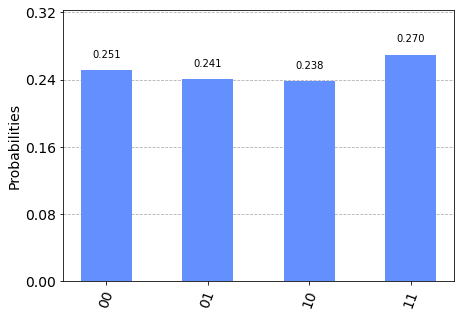

In [347]:
qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(qc, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)


ibmqfactory.load_account:WARNING:2021-03-11 20:35:41,572: Credentials are already in use. The existing account in the session will be replaced.


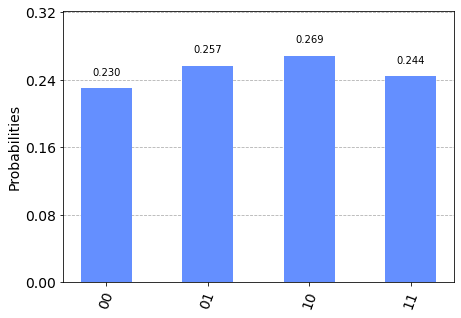

In [32]:
IBMQ.load_account() # Load account from disk
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_qasm_simulator')

shots = 1024
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [28]:
print(answer)

{'00': 245, '01': 253, '10': 268, '11': 258}


In [29]:
import operator
max(answer.items(), key=operator.itemgetter(1))[0]

'10'